In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results_dir = Path("results")
results_err_dir = Path("results_error")
results_err_dir.mkdir(parents=True, exist_ok=True)

SYSTEM_SIZE = 16
TRAIN_SAMPLES = 20_000

ATOL_H = 1e-3

In [3]:
csv_path = results_dir / f"eval_results_L{SYSTEM_SIZE}_N{TRAIN_SAMPLES}.csv"
ref_path = Path(f"tfim_{SYSTEM_SIZE}_entangle_ref.csv")  # optional ED reference

df = pd.read_csv(csv_path)

# expected columns: seed, h, l, s2, s2_err, type
needed = {"seed", "h", "l", "s2", "s2_err", "type"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in {csv_path.name}: {sorted(missing)}")

# support h values (from your evaluation output)
h_support_vals = sorted(df.loc[df["type"] == "support", "h"].unique())
seeds = sorted(df["seed"].unique())
l_axis = sorted(df["l"].unique())

print(f"Loaded: {csv_path.name}")
print(f"Rows: {len(df)}")
print(f"Seeds: {len(seeds)} -> {seeds[:10]}{' ...' if len(seeds) > 10 else ''}")
print(f"Support h: {len(h_support_vals)} -> {h_support_vals}")
print(f"l-range: {min(l_axis)}..{max(l_axis)}")

ref_df = pd.read_csv(ref_path) if ref_path.exists() else None
print(f"ED ref: {'loaded' if ref_df is not None else 'not found'} ({ref_path.name})")

Loaded: eval_results_L16_N20000.csv
Rows: 1680
Seeds: 10 -> [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
Support h: 7 -> [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5]
l-range: 1..8
ED ref: loaded (tfim_16_entangle_ref.csv)


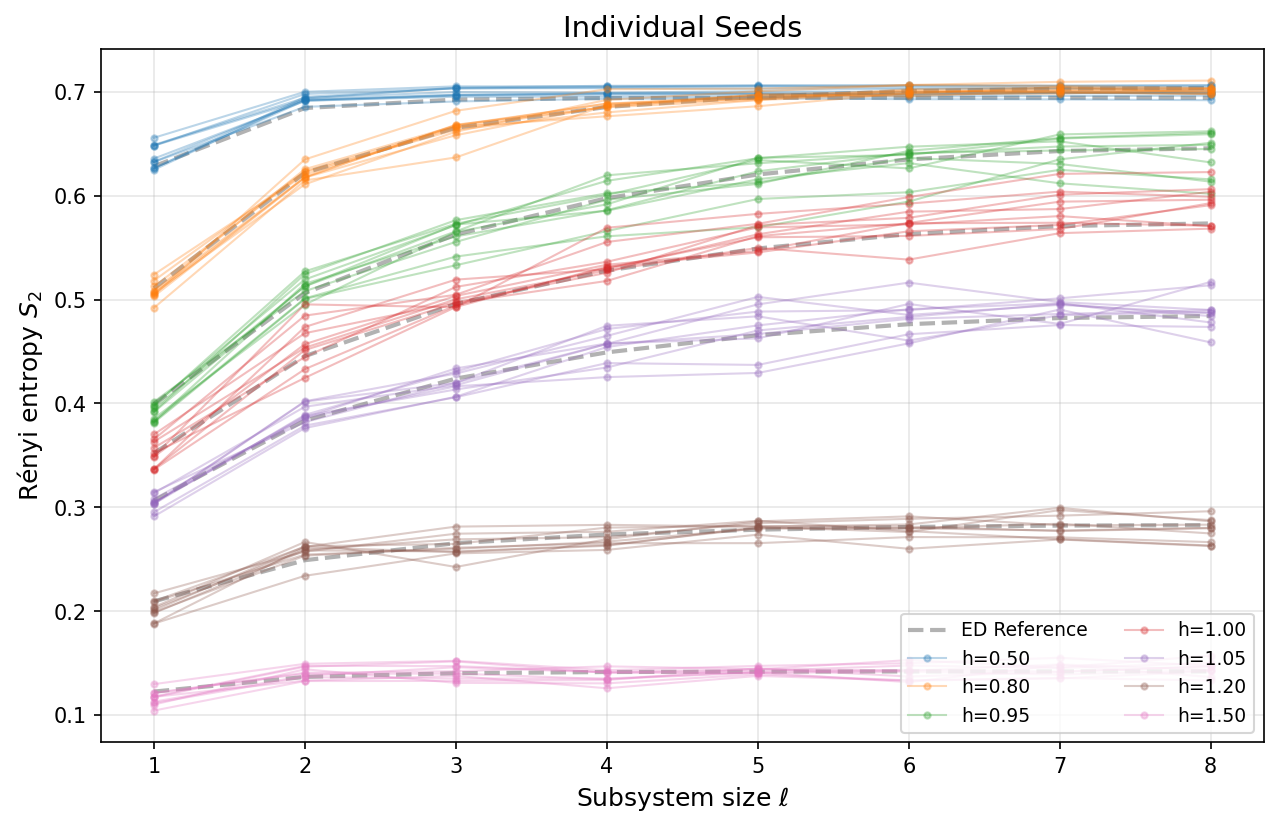

In [5]:
# Cell 3 - plot (individual seeds) - FAST + reliable display
from IPython.display import display

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
cmap = plt.get_cmap("tab10")

# ED reference lines
if ref_df is not None:
    ref_lbl_added = False
    for h in h_support_vals:
        mask = np.isclose(ref_df["h"], h, atol=ATOL_H)
        if mask.any():
            l_cols = sorted(
                [c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_axis],
                key=lambda s: int(s[1:])
            )
            if l_cols:
                y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
                x_ref = [int(c[1:]) for c in l_cols]
                lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
                ax.plot(x_ref, y_ref, "--", color="gray", linewidth=2, alpha=0.6, label=lbl)
                ref_lbl_added = True

# IMPORTANT: plotting errorbars for every seed is what usually "hangs".
# So: plot seeds as lines+markers (fast). Error bars belong on the averaged plot.
for i, h in enumerate(h_support_vals):
    color = cmap(i % 10)
    subset_h = df[(df["type"] == "support") & np.isclose(df["h"], h, atol=ATOL_H)]

    for seed in seeds:
        sub = subset_h[subset_h["seed"] == seed].sort_values("l")
        if sub.empty:
            continue
        lbl = f"h={h:.2f}" if seed == seeds[0] else "_nolegend_"
        ax.plot(sub["l"], sub["s2"], "o-", color=color, markersize=3,
                linewidth=1.0, alpha=0.30, label=lbl)

ax.set_title("Individual Seeds", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2, fontsize=9)

display(fig)
plt.close(fig)

In [6]:
# Stats (median + std across seeds), in the same spirit as your chi snippet

K = None  # set e.g. 10 to mimic all_results[:10], or None for all seeds

df_sup = df[df["type"] == "support"].copy()

h_support_vals = sorted(df_sup["h"].unique())
l_axis = sorted(df_sup["l"].unique())
seeds = sorted(df_sup["seed"].unique())
sel_seeds = seeds[:K] if K is not None else seeds

stats_rows = []

for h in h_support_vals:
    sub = df_sup[np.isclose(df_sup["h"], h, atol=ATOL_H)]

    # matrix: (num_seeds, num_l)
    mat = (
        sub.pivot(index="seed", columns="l", values="s2")
        .reindex(index=sel_seeds, columns=l_axis)
        .to_numpy()
    )

    # "mean" via median, "error" via std (exactly like your chi code)
    s2_med = np.nanmedian(mat, axis=0)
    s2_std = np.nanstd(mat, axis=0)  # ddof=0, matches np.std default
    n_eff  = np.sum(~np.isnan(mat), axis=0)

    for l, m, e, n in zip(l_axis, s2_med, s2_std, n_eff):
        stats_rows.append(
            {"h": float(h), "l": int(l), "s2_median": float(m), "s2_std": float(e), "n": int(n)}
        )

stats_df = pd.DataFrame(stats_rows).sort_values(["h", "l"]).reset_index(drop=True)
stats_df

,h,l,s2_median,s2_std,n
0,0.50,1,0.634269,0.010717,10
1,0.50,2,0.693084,0.003745,10
2,0.50,3,0.698634,0.004466,10
3,0.50,4,0.699041,0.004123,10
4,0.50,5,0.699885,0.004201,10
5,0.50,6,0.699171,0.004301,10
6,0.50,7,0.699675,0.004018,10
7,0.50,8,0.699687,0.004319,10
8,0.80,1,0.506946,0.008297,10
9,0.80,2,0.619272,0.006291,10


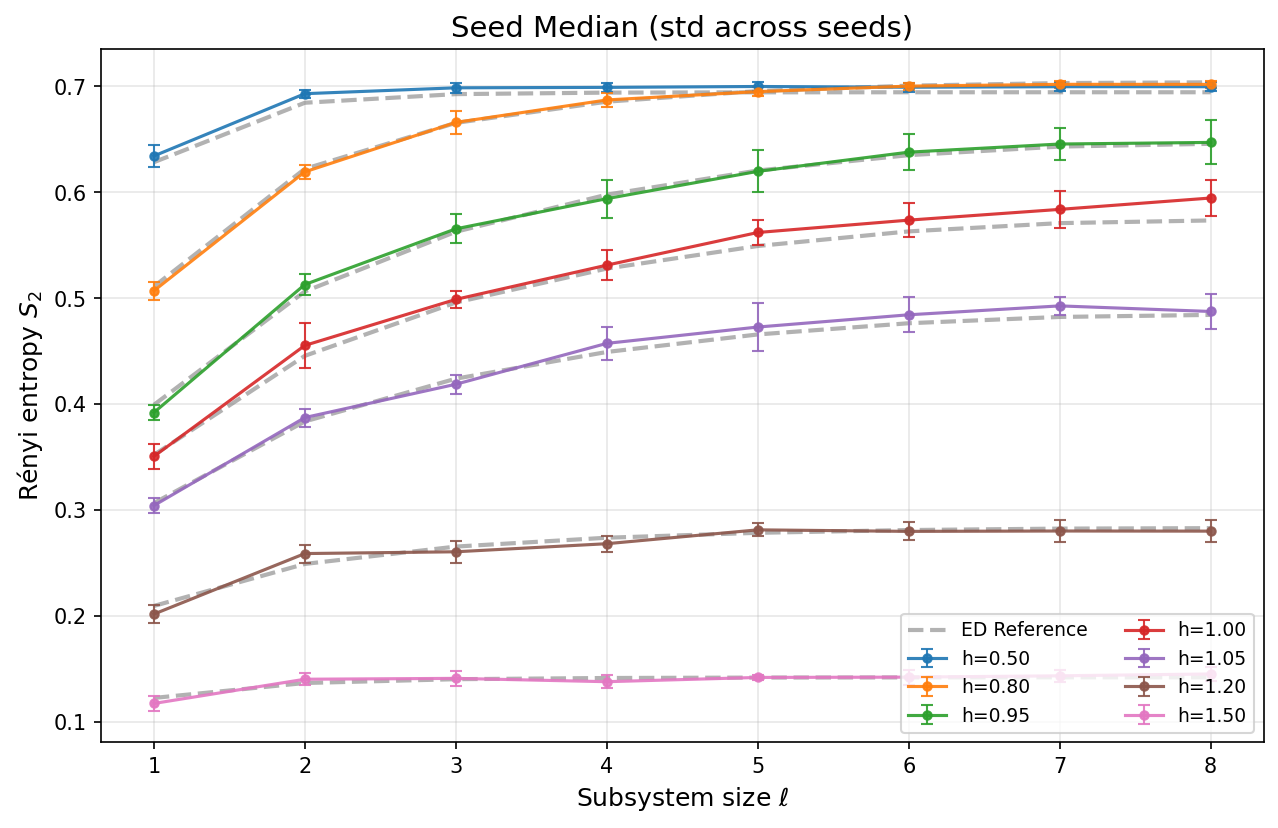

In [7]:
# Plot on stats_df (median + std across seeds)
from IPython.display import display

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
cmap = plt.get_cmap("tab10")

# ED reference overlay (same logic as before)
if ref_df is not None:
    ref_lbl_added = False
    for h in h_support_vals:
        mask = np.isclose(ref_df["h"], h, atol=ATOL_H)
        if mask.any():
            l_cols = sorted(
                [c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_axis],
                key=lambda s: int(s[1:])
            )
            if l_cols:
                y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
                x_ref = [int(c[1:]) for c in l_cols]
                lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
                ax.plot(x_ref, y_ref, "--", color="gray", linewidth=2, alpha=0.6, label=lbl)
                ref_lbl_added = True

# Median + std error bars from stats_df
for i, h in enumerate(h_support_vals):
    color = cmap(i % 10)
    sub = stats_df[np.isclose(stats_df["h"], h, atol=ATOL_H)].sort_values("l")
    if sub.empty:
        continue

    ax.errorbar(
        sub["l"], sub["s2_median"], yerr=sub["s2_std"],
        fmt="o-", color=color, markersize=4, linewidth=1.5,
        elinewidth=1.0, capsize=3, alpha=0.9, label=f"h={h:.2f}"
    )

ax.set_title("Seed Median (std across seeds)", fontsize=14)
ax.set_xlabel(r"Subsystem size $\ell$", fontsize=12)
ax.set_ylabel(r"Rényi entropy $S_2$", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2, fontsize=9)

display(fig)
plt.close(fig)